# Anomaly Generation and Two-Branch Decoder Analysis

Analyze the anomaly-generation and mask pipeline used in stage-2 training, and verify that:
- **General decoder** outputs **x_g** (spectrogram **with** anomalies).
- **Object-specific decoder** outputs **x_s** (spectrogram **without** anomalies).

We use controlled fake anomalies to illustrate the training-phase process.

## 1. Setup and imports

Paths, imports, and optional load of trained sDSR. If checkpoints are missing, the model is built with random weights (visualizations show "signal flow" only; the x_s "without anomaly" effect is strong only after training).

In [1]:
# Setup and paths
import sys
from pathlib import Path

_cwd = Path(".").resolve()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

CKPT_DIR = PROJECT_ROOT / "checkpoints"
MACHINE_TYPE = "fan"
STAGE1_CKPT = CKPT_DIR / "stage1" / MACHINE_TYPE / "stage1_fan_best.pt"
STAGE2_CKPT = CKPT_DIR / "stage2" / MACHINE_TYPE / "stage2_fan_best.pt"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_mels, T = 128, 320

# q_shape used by sDSR (H = n_mels//4, W = T//4)
def get_q_shape(n_mels, T):
    return (max(1, n_mels // 4), max(1, T // 4))

q_shape = get_q_shape(n_mels, T)
H_q, W_q = q_shape[0], q_shape[1]
spectrogram_shape = (n_mels, T)
print(f"Device: {DEVICE}, n_mels={n_mels}, T={T}, q_shape={q_shape}")

Device: cuda, n_mels=128, T=320, q_shape=(32, 80)


In [2]:
# Build and optionally load sDSR (same as stage2_analysis / scripts/train.py)
from src.models.vq_vae.autoencoders import VQ_VAE_2Layer
from src.models.sDSR.s_dsr import sDSR, sDSRConfig
from src.utils.anomalies import AnomalyMapGenerator

def build_vq_vae(n_mels: int, T: int):
    return VQ_VAE_2Layer(
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        num_embeddings=(4096, 4096),
        embedding_dim=128,
        commitment_cost=0.25,
        decay=0.99,
    )

def build_s_dsr(vq_vae, n_mels: int, T: int):
    cfg = sDSRConfig(
        embedding_dim=128,
        num_hiddens=128,
        num_residual_layers=2,
        num_residual_hiddens=64,
        n_mels=n_mels,
        T=T,
    )
    return sDSR(vq_vae, cfg)

vq_vae = build_vq_vae(n_mels, T)
load_trained = STAGE1_CKPT.exists()
if load_trained:
    ckpt_s1 = torch.load(STAGE1_CKPT, map_location="cpu", weights_only=False)
    vq_vae.load_state_dict(ckpt_s1["model_state_dict"])
model = build_s_dsr(vq_vae, n_mels, T)
if STAGE2_CKPT.exists():
    ckpt_s2 = torch.load(STAGE2_CKPT, map_location="cpu", weights_only=False)
    model.load_state_dict(ckpt_s2["model_state_dict"])
else:
    print("Stage2 checkpoint not found; using random weights (signal-flow demo only).")
model = model.to(DEVICE)
model.eval()
print("Model ready (eval mode).")

Model ready (eval mode).


## 2. Anomaly map and mask visualization

**2a.** Create a synthetic mask (e.g. rectangle in the center) at q_shape and visualize it at spectrogram size.  
**2b.** Generate a few masks with `AnomalyMapGenerator` (Perlin and/or audio-specific) to show blob vs band patterns.

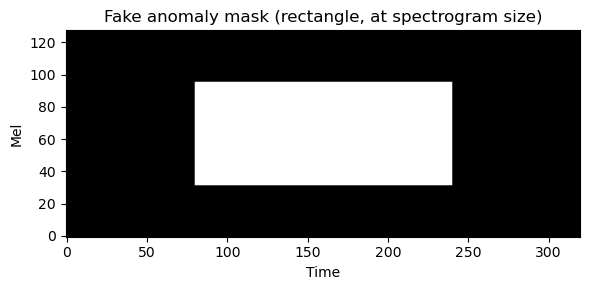

M_fake shape: torch.Size([1, 1, 32, 80]) (q_space); viz shape: torch.Size([1, 1, 128, 320])


In [3]:
# 2a. Fake anomaly mask (controlled): rectangle at q_shape
H_q, W_q = q_shape
M_fake = torch.zeros(1, 1, H_q, W_q)
# Rectangle in the center (e.g. 25% of each dimension)
h_start, h_end = H_q // 4, 3 * H_q // 4
w_start, w_end = W_q // 4, 3 * W_q // 4
M_fake[:, :, h_start:h_end, w_start:w_end] = 1.0

# Resize to spectrogram size for visualization
M_fake_viz = F.interpolate(M_fake.float(), size=(n_mels, T), mode="nearest")
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(M_fake_viz[0, 0].numpy(), aspect="auto", cmap="gray", origin="lower")
ax.set_xlabel("Time")
ax.set_ylabel("Mel")
ax.set_title("Fake anomaly mask (rectangle, at spectrogram size)")
plt.tight_layout()
plt.show()
print(f"M_fake shape: {M_fake.shape} (q_space); viz shape: {M_fake_viz.shape}")

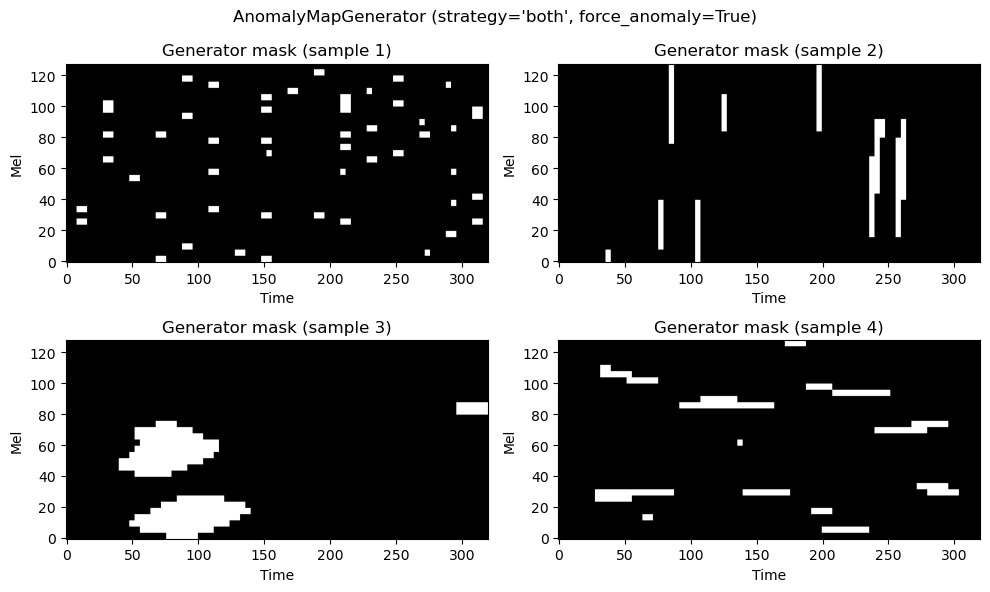

In [4]:
# 2b. Generator-based masks (Perlin + audio-specific)
gen = AnomalyMapGenerator(
    strategy="both",
    spectrogram_shape=spectrogram_shape,
    q_shape=q_shape,
    n_mels=n_mels,
    T=T,
    zero_mask_prob=0.0,
)
M_perlin = gen.generate(2, "cpu", force_anomaly=True)
M_audio = gen.generate(2, "cpu", force_anomaly=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for i in range(2):
    m = F.interpolate(M_perlin[i:i+1].float(), size=(n_mels, T), mode="nearest")
    axes[0, i].imshow(m[0, 0].numpy(), aspect="auto", cmap="gray", origin="lower")
    axes[0, i].set_title(f"Generator mask (sample {i+1})")
for i in range(2):
    m = F.interpolate(M_audio[i:i+1].float(), size=(n_mels, T), mode="nearest")
    axes[1, i].imshow(m[0, 0].numpy(), aspect="auto", cmap="gray", origin="lower")
    axes[1, i].set_title(f"Generator mask (sample {i+3})")
for ax in axes.flat:
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel")
plt.suptitle("AnomalyMapGenerator (strategy='both', force_anomaly=True)")
plt.tight_layout()
plt.show()

## 3. Two-branch decoder test with fake anomalies

**3a.** Single-sample controlled run: one normal spectrogram `x`, known `M_gt`, then `forward_train(x, M_gt=M_fake)`.  
**3b.** Visual comparison: input **x**, **x_g** (with anomaly), **x_s** (without anomaly), and **M**.  
**3c.** Quantitative: mean |x_g − x| and |x_s − x| inside vs outside mask.

In [5]:
# 3a. Single-sample controlled run
# Synthetic normal spectrogram (smooth pattern so "normal" is clear)
torch.manual_seed(42)
x = torch.randn(1, 1, n_mels, T, device=DEVICE) * 0.5
# Optional: make it smoother for clearer visuals
x = F.avg_pool2d(x, 5, stride=1, padding=2)

# Known mask at q_shape (same rectangle as in section 2)
M_gt = M_fake.to(DEVICE)

with torch.no_grad():
    out = model.forward_train(x, M_gt=M_gt)

x_in = out["x"]
x_g = out["x_g"]
x_s = out["x_s"]
M_for_viz = out["M"]

print("Shapes: x", x_in.shape, "x_g", x_g.shape, "x_s", x_s.shape, "M", M_for_viz.shape)

Shapes: x torch.Size([1, 1, 128, 320]) x_g torch.Size([1, 1, 128, 320]) x_s torch.Size([1, 1, 128, 320]) M torch.Size([1, 1, 128, 320])


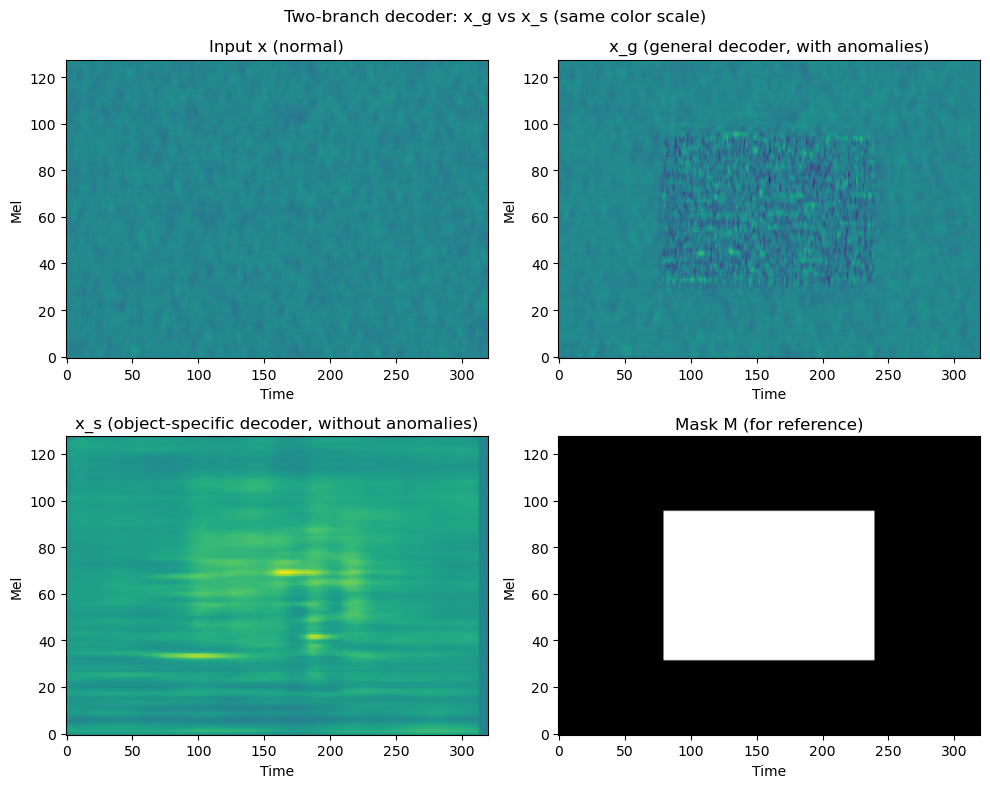

In [6]:
# 3b. Visual comparison: x (normal), x_g (with anomaly), x_s (without anomaly), M
vmin = min(x_in.min().item(), x_g.min().item(), x_s.min().item())
vmax = max(x_in.max().item(), x_g.max().item(), x_s.max().item())

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].imshow(x_in[0, 0].cpu().numpy(), aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("Input x (normal)")
axes[0, 1].imshow(x_g[0, 0].cpu().numpy(), aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("x_g (general decoder, with anomalies)")
axes[1, 0].imshow(x_s[0, 0].cpu().numpy(), aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("x_s (object-specific decoder, without anomalies)")
axes[1, 1].imshow(M_for_viz[0, 0].cpu().numpy(), aspect="auto", origin="lower", cmap="gray")
axes[1, 1].set_title("Mask M (for reference)")
for ax in axes.flat:
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel")
plt.suptitle("Two-branch decoder: x_g vs x_s (same color scale)")
plt.tight_layout()
plt.show()

In [7]:
# 3c. Quantitative check: mean absolute difference inside vs outside mask
M_bool = (M_for_viz[0, 0] > 0.5).float()
diff_g = (x_g[0, 0] - x_in[0, 0]).abs()
diff_s = (x_s[0, 0] - x_in[0, 0]).abs()

inside = M_bool > 0.5
outside = 1.0 - M_bool
n_in = inside.sum().clamp(min=1).item()
n_out = outside.sum().clamp(min=1).item()

mad_g_in = (diff_g * inside).sum().item() / n_in
mad_g_out = (diff_g * outside).sum().item() / n_out
mad_s_in = (diff_s * inside).sum().item() / n_in
mad_s_out = (diff_s * outside).sum().item() / n_out

print("Mean absolute difference (general decoder x_g vs input x):")
print(f"  Inside mask:  {mad_g_in:.4f}")
print(f"  Outside mask: {mad_g_out:.4f}")
print("Mean absolute difference (object decoder x_s vs input x):")
print(f"  Inside mask:  {mad_s_in:.4f}")
print(f"  Outside mask: {mad_s_out:.4f}")
print("Expected: inside mask, diff_g large (anomaly in x_g), diff_s smaller (x_s reconstructs normal).")

Mean absolute difference (general decoder x_g vs input x):
  Inside mask:  0.3436
  Outside mask: 0.0514
Mean absolute difference (object decoder x_s vs input x):
  Inside mask:  0.8734
  Outside mask: 0.4690
Expected: inside mask, diff_g large (anomaly in x_g), diff_s smaller (x_s reconstructs normal).


## 4. Batch with mixed normal / anomalous (mirror training)

Create a batch of 4: first 2 with M=0 (normal), last 2 with a fixed fake M. Pass explicit `M_gt` and run `forward_train(x_batch, M_gt=M_gt)`. Plot one sample from the normal half and one from the anomalous half.

In [ ]:
# Batch of 4: first 2 normal (M=0), last 2 with fake anomaly mask
batch_size = 4
half = batch_size // 2
torch.manual_seed(123)
x_batch = torch.randn(batch_size, 1, n_mels, T, device=DEVICE) * 0.5
x_batch = F.avg_pool2d(x_batch, 5, stride=1, padding=2)

M_zeros = torch.zeros(half, 1, H_q, W_q, device=DEVICE)
M_fake_batch = M_fake.expand(half, 1, H_q, W_q).to(DEVICE)
M_gt_batch = torch.cat([M_zeros, M_fake_batch], dim=0)

with torch.no_grad():
    out_batch = model.forward_train(x_batch, M_gt=M_gt_batch)

x_b = out_batch["x"]
x_g_b = out_batch["x_g"]
x_s_b = out_batch["x_s"]
M_b = out_batch["M"]
print("Batch shapes:", x_b.shape, x_g_b.shape, x_s_b.shape, M_b.shape)

In [ ]:
# Plot: one sample from normal half (idx 0), one from anomalous half (idx 2)
vmin = x_b.min().item()
vmax = x_b.max().item()

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
# Normal half: sample 0
for j, (tensor, title) in enumerate([
    (x_b[0], "x (input)"),
    (x_g_b[0], "x_g"),
    (x_s_b[0], "x_s"),
    (M_b[0], "M"),
]):
    ax = axes[0, j]
    if "M" in title:
        ax.imshow(tensor[0].cpu().numpy(), aspect="auto", origin="lower", cmap="gray")
    else:
        ax.imshow(tensor[0].cpu().numpy(), aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    ax.set_title(f"Normal half [0] — {title}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel")
# Anomalous half: sample 2
for j, (tensor, title) in enumerate([
    (x_b[2], "x (input)"),
    (x_g_b[2], "x_g"),
    (x_s_b[2], "x_s"),
    (M_b[2], "M"),
]):
    ax = axes[1, j]
    if "M" in title:
        ax.imshow(tensor[0].cpu().numpy(), aspect="auto", origin="lower", cmap="gray")
    else:
        ax.imshow(tensor[0].cpu().numpy(), aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    ax.set_title(f"Anomalous half [2] — {title}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Mel")
plt.suptitle("Batch: normal half vs anomalous half (x_g with anomaly, x_s closer to normal)")
plt.tight_layout()
plt.show()

## 5. Training-phase pipeline (step-by-step)

```mermaid
flowchart LR
  subgraph encode [Encode]
    X["x (normal)"] --> Enc["encoder"]
    Enc --> Q["q_bot, q_top"]
  end
  Q --> Anom["anomaly module + M"]
  Anom --> Qa["q_bot_a, q_top_a"]
  Qa --> GenDec["general decoder"]
  Qa --> ObjDec["object decoder"]
  GenDec --> Xg["x_g (with anomalies)"]
  ObjDec --> Xs["x_s (without anomalies)"]
  Xg --> Focal["focal loss vs M"]
  Xs --> L2["L2 loss vs x"]
```
- **Branch 1:** General decoder gets anomalous q → **x_g** (spectrogram with anomalies).  
- **Branch 2:** Object decoder gets same anomalous q, trained with L2 to match normal **x** → **x_s** (spectrogram without anomalies).  
- **M** is the anomaly mask; used as target for segmentation (focal loss).